In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
from keras import backend as K 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
import json
import math
import csv
import gzip
import codecs
import matplotlib
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle
from deeplift.visualization import viz_sequence
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from sklearn.linear_model import LinearRegression
%matplotlib inline
font = {'weight' : 'bold', 'size'   : 14}

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3,5"

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [3]:
seq_len = 546
out_pred_len = 200
test_chrms = ["chrX", "chrXI"]
peaks = []
bedfile = "data/pho4_pbexo/pho4.pbexo.bed"
with open(bedfile) as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + 1
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        if len(GenomeDict[chrm][start:end].upper()) == seq_len:
            peaks.append(GenomeDict[chrm][start:end].upper())

In [4]:
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("/users/amr1/pho4/data/models/pho4_pbexo_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [5]:
ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [6]:
num_samples = 100
bp = ['A','C','G','T']
flank_consensus = "AAAAAAAAAA"
consensus = "AAAAACACGTGAAAAA"
distilled_matrix = np.zeros((16,4))
for idx in range(16):
    for idy in range(4):
        new_seq = list(consensus)
        new_seq[idx] = bp[idy]
        pre_seqs = []
        post_seqs = []
        insert = "".join(new_seq)
        insert_len = len(insert)
        start = int((seq_len/2)-(insert_len/2))
        indices = np.random.choice(len(peaks), num_samples, replace=False)
        for idz in indices:
            pre_seq = dinuc_shuffle(peaks[idz])
            post_seq = pre_seq[:start] + insert + pre_seq[start+insert_len:]
            pre_seqs.append(pre_seq)
            post_seqs.append(post_seq)
        pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
        distilled_matrix[idx][idy] = np.mean(post[0]-pre[0])

In [7]:
lines = []
with open('data/experimental/PSAMs/Pho4_PSAM_extended.csv') as handle:
    reader = csv.reader(handle)
    for row in reader:
        lines.append(row)
PHO4_PSAM = np.array(lines)[1:,0:].T.astype('float')

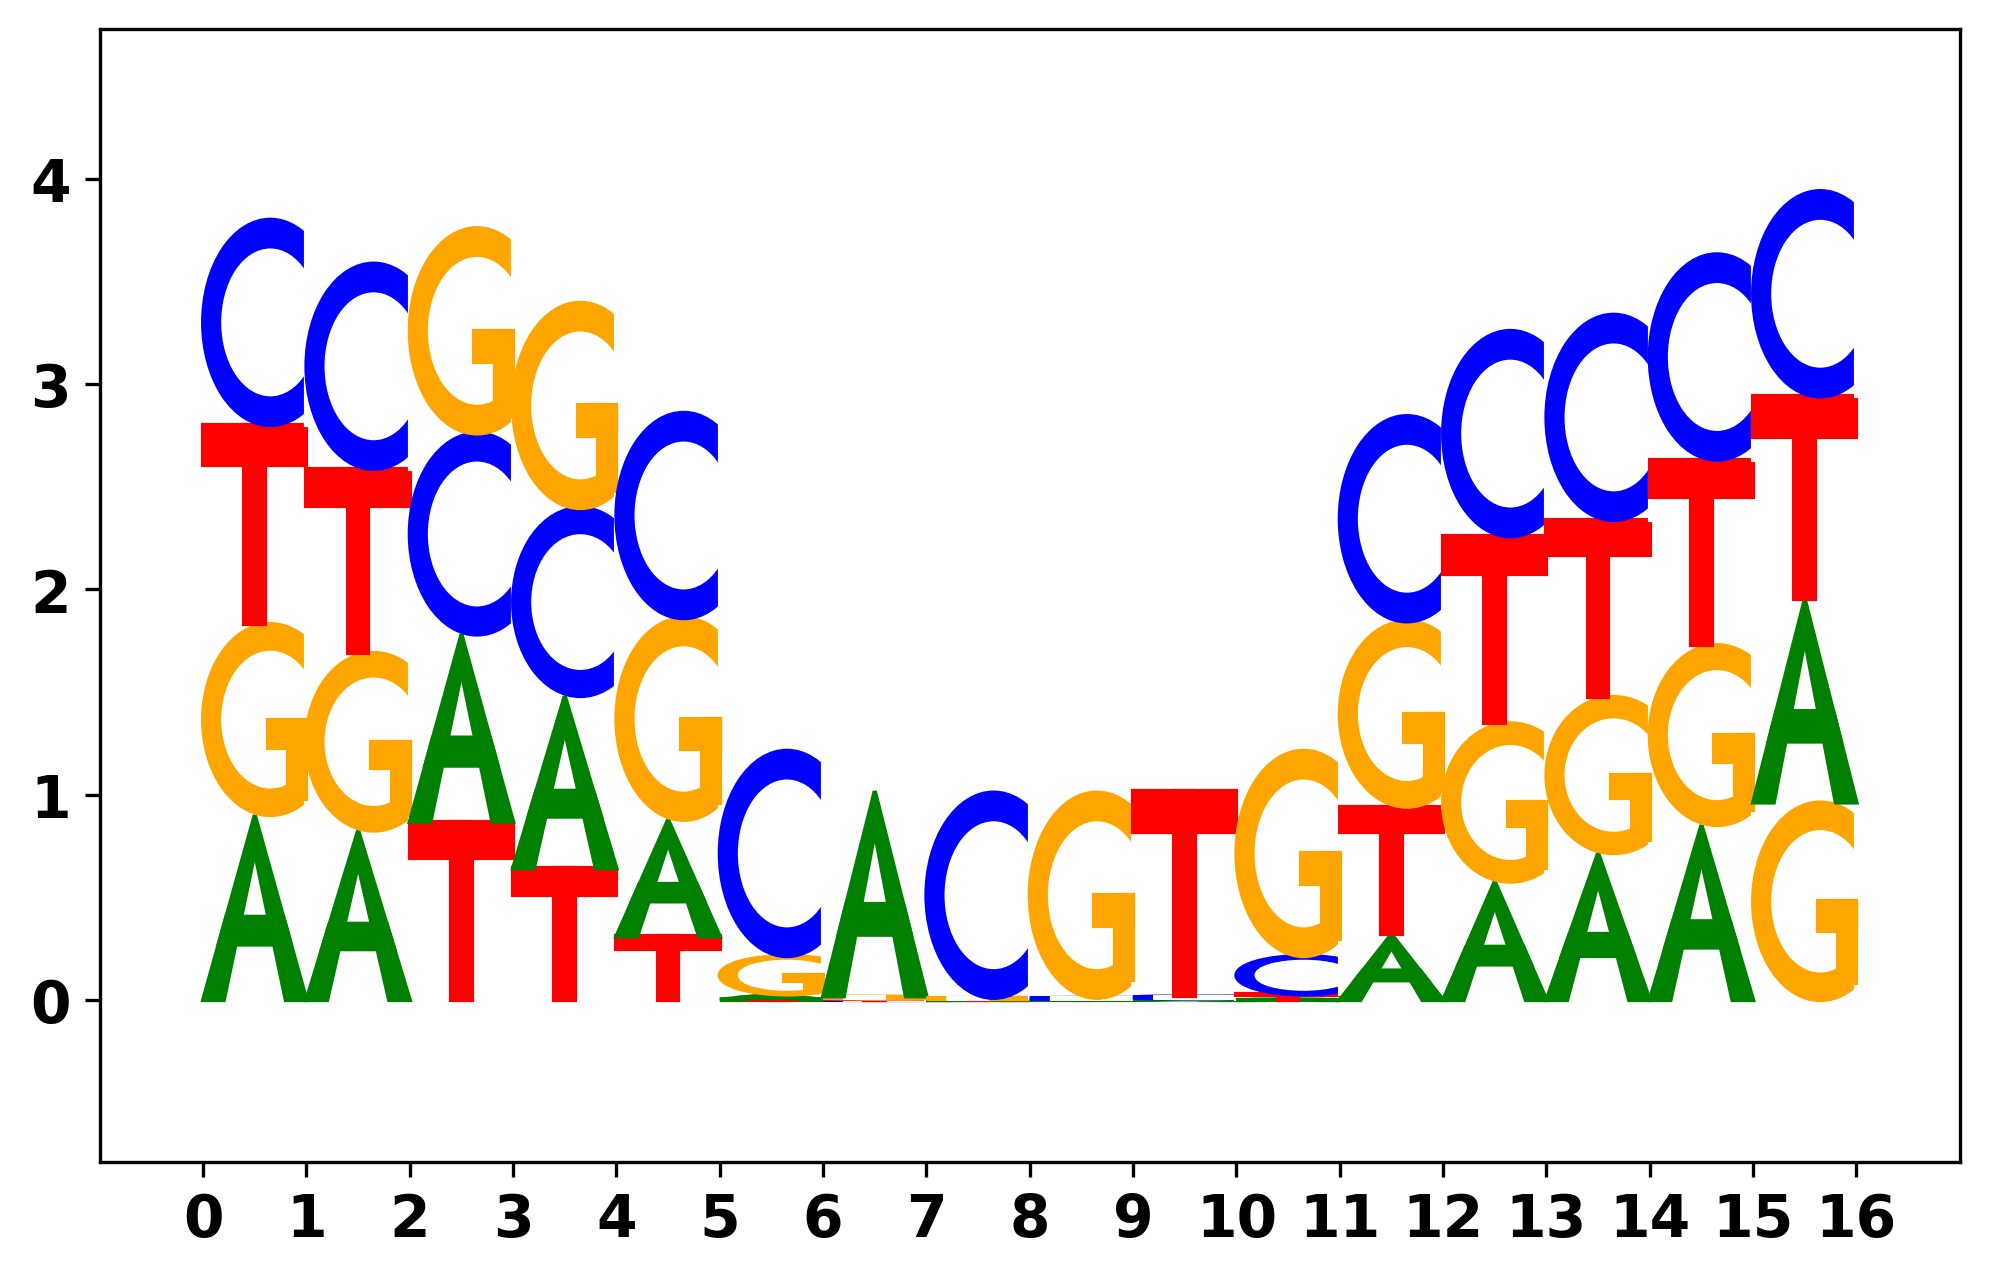

In [8]:
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_PSAM,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

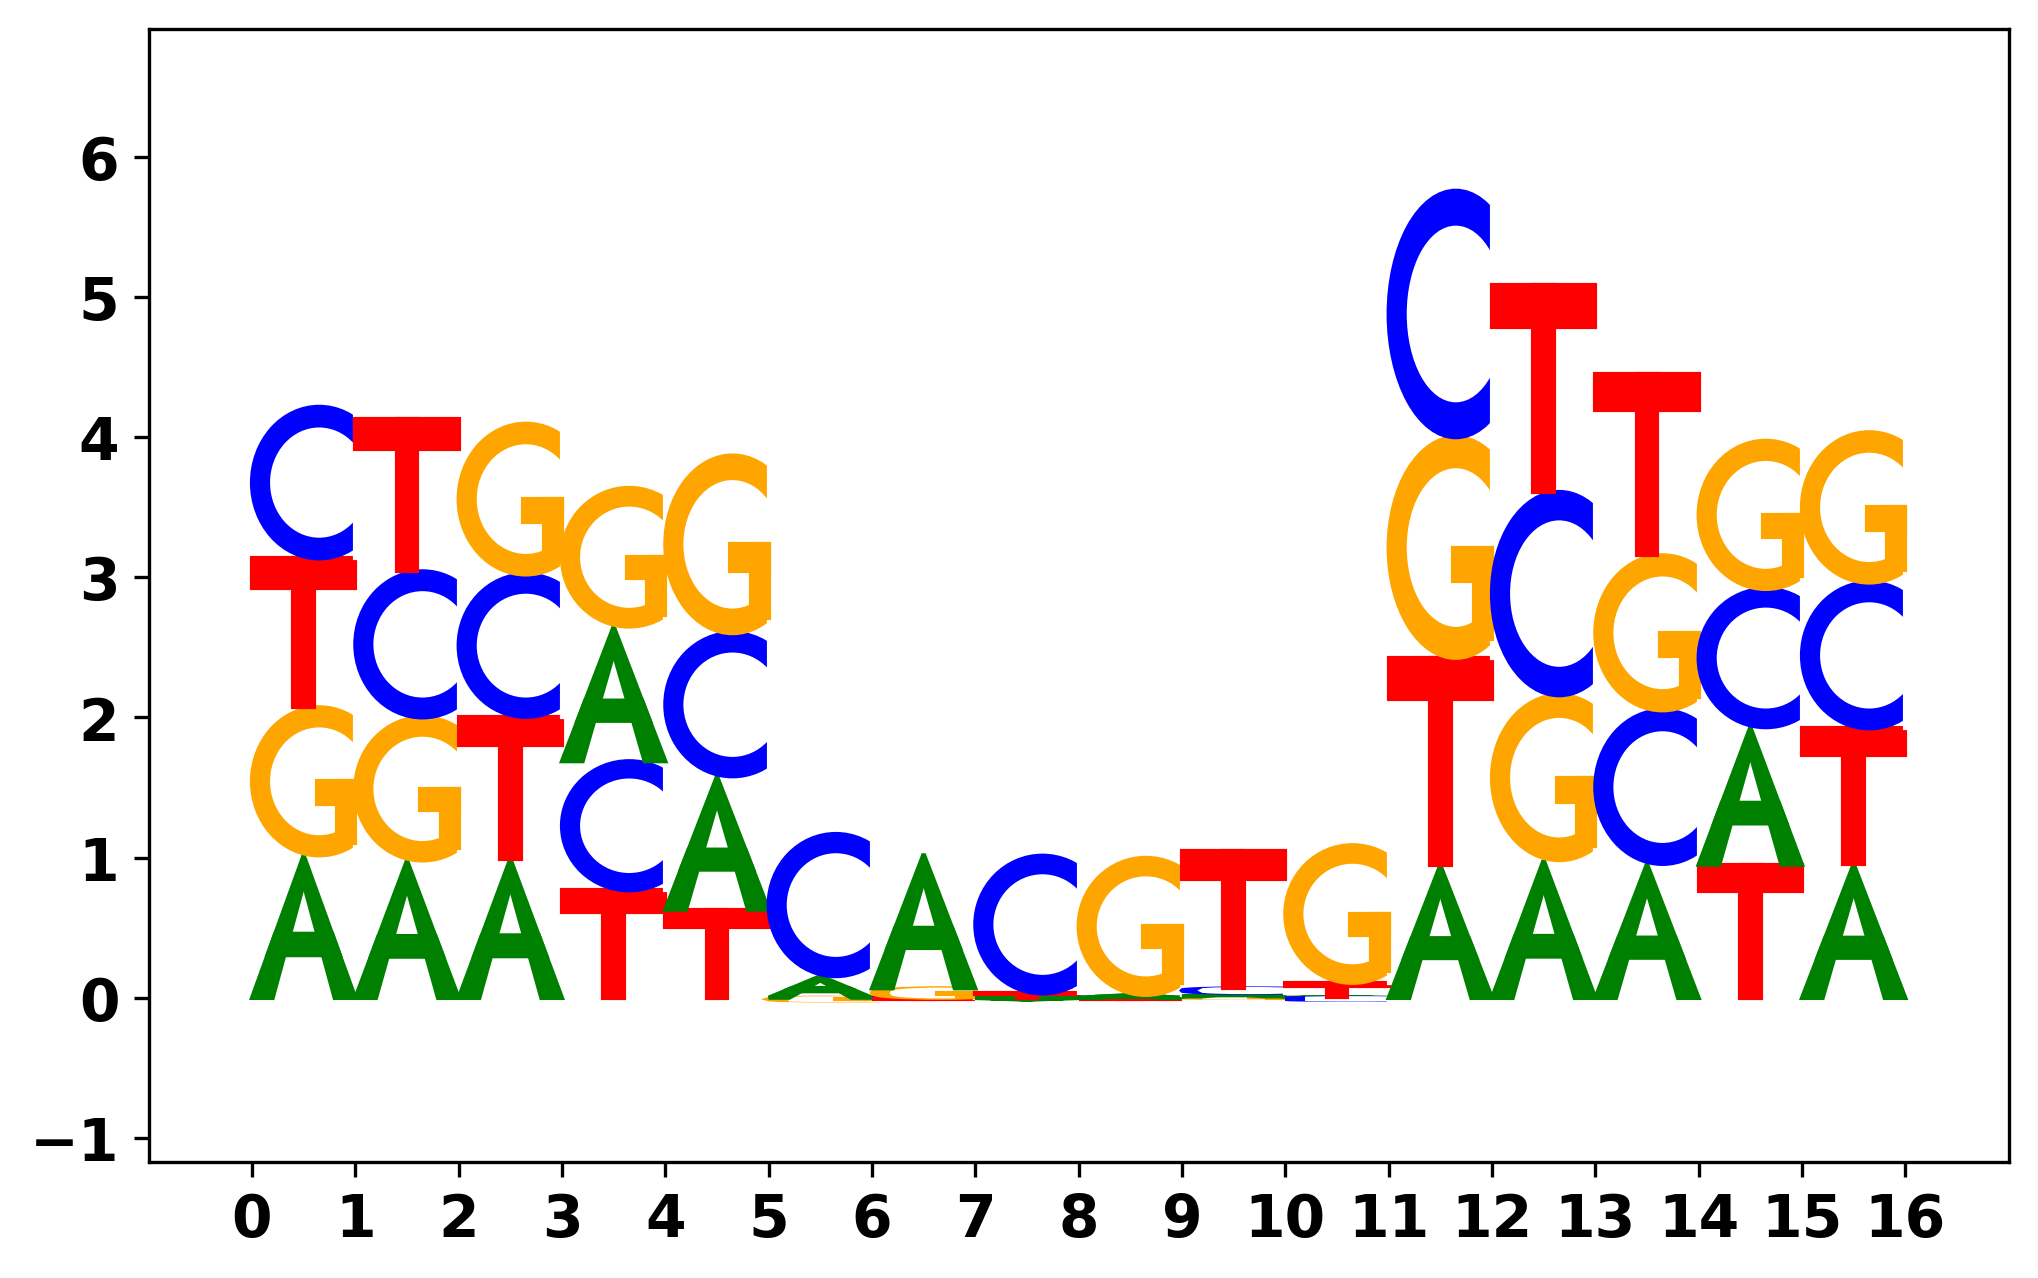

In [9]:
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, distilled_matrix,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

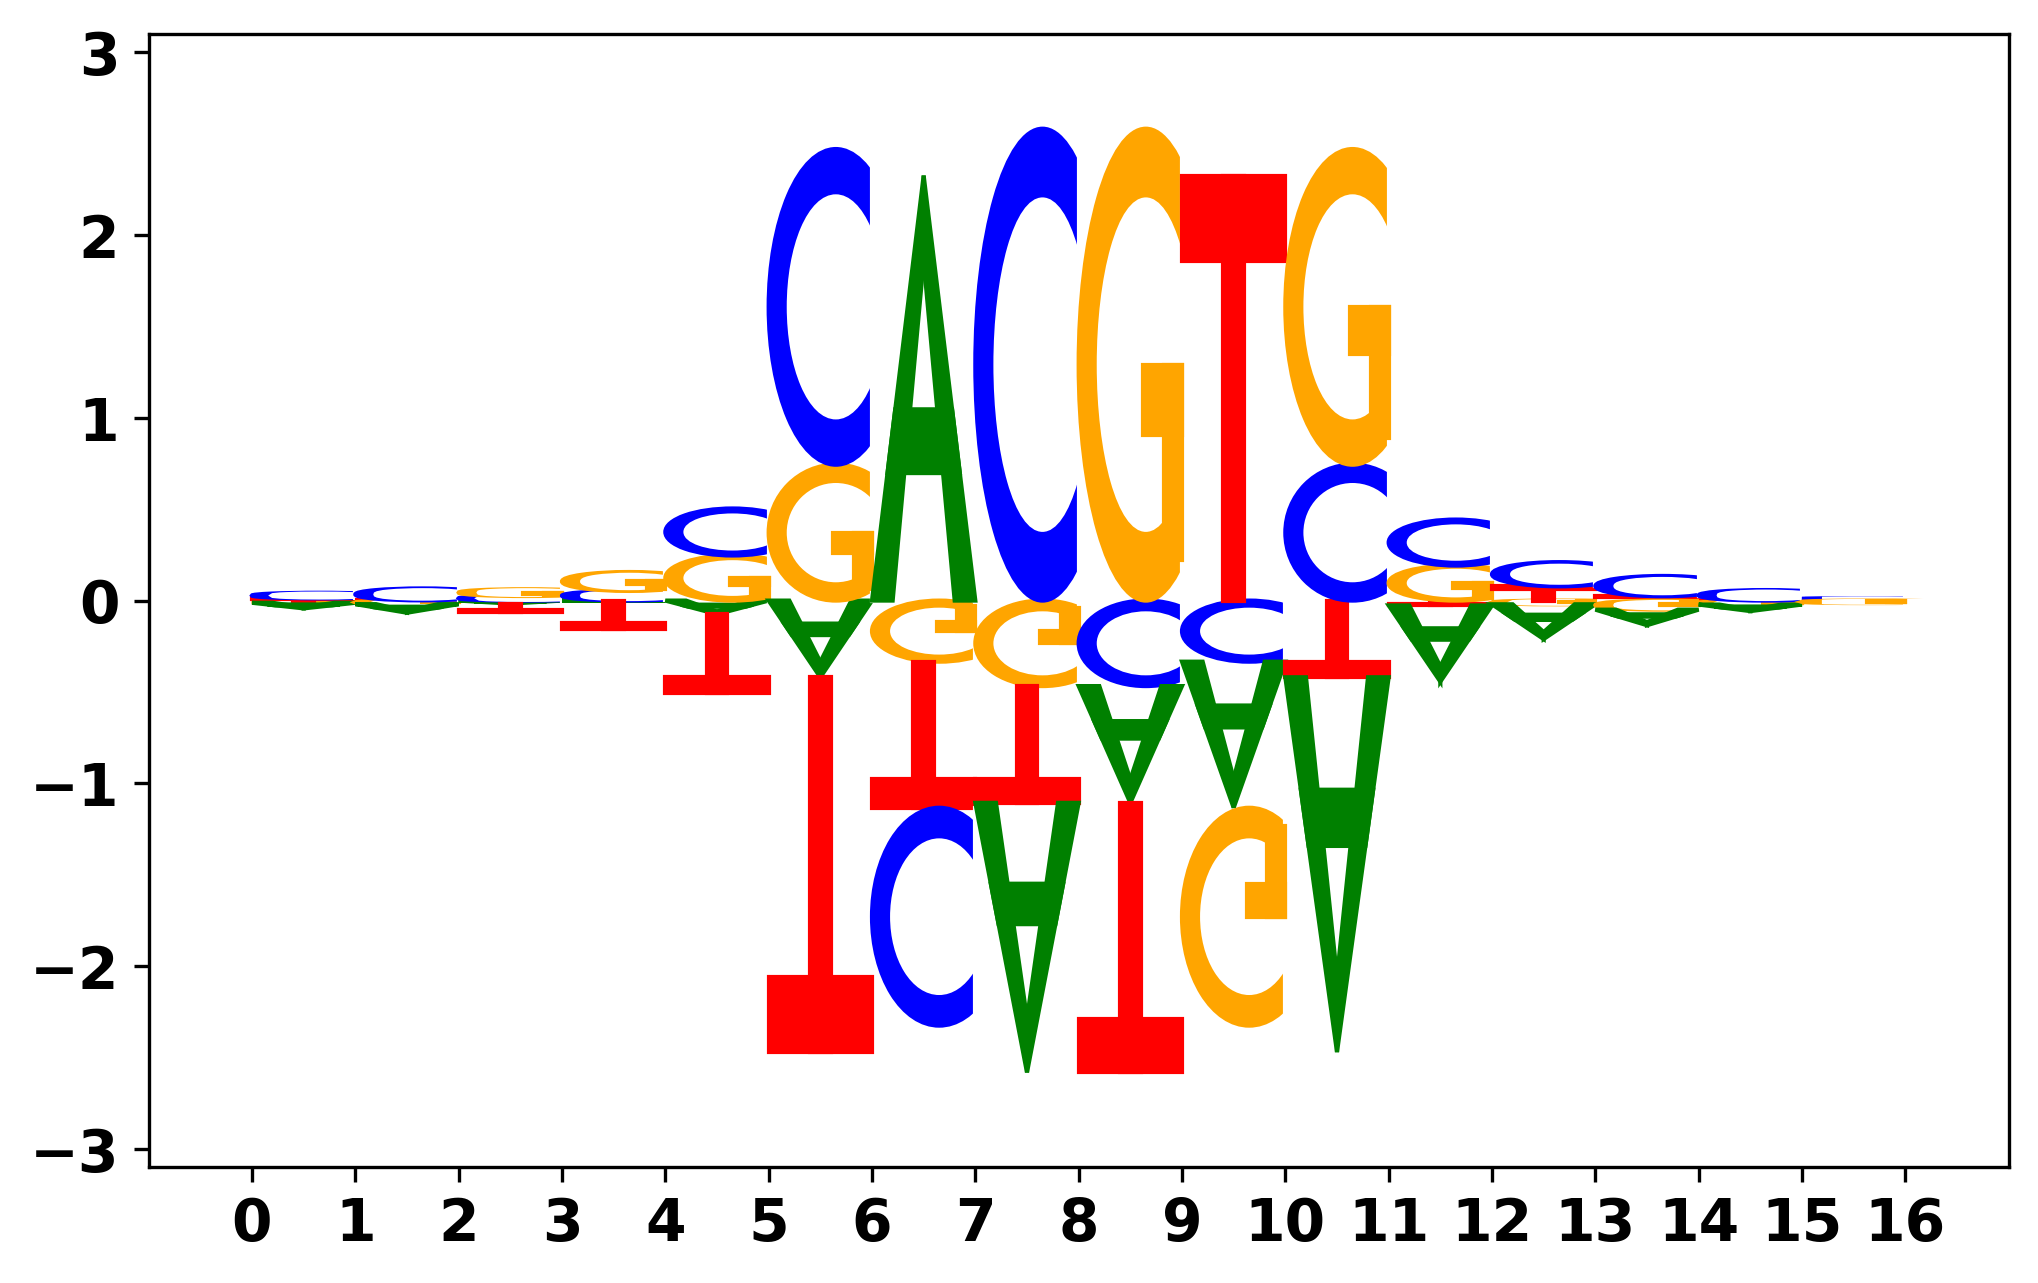

In [10]:
def ddG(Kd1, Kd2, R=1.9872036e-3, T=295):
    return R*T*np.log(Kd2/Kd1)
PHO4_ddG = [[-ddG(x,1) for x in j] for j in PHO4_PSAM]
PHO4_ddG = np.array([i-np.mean(i) for i in PHO4_ddG])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, PHO4_ddG,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

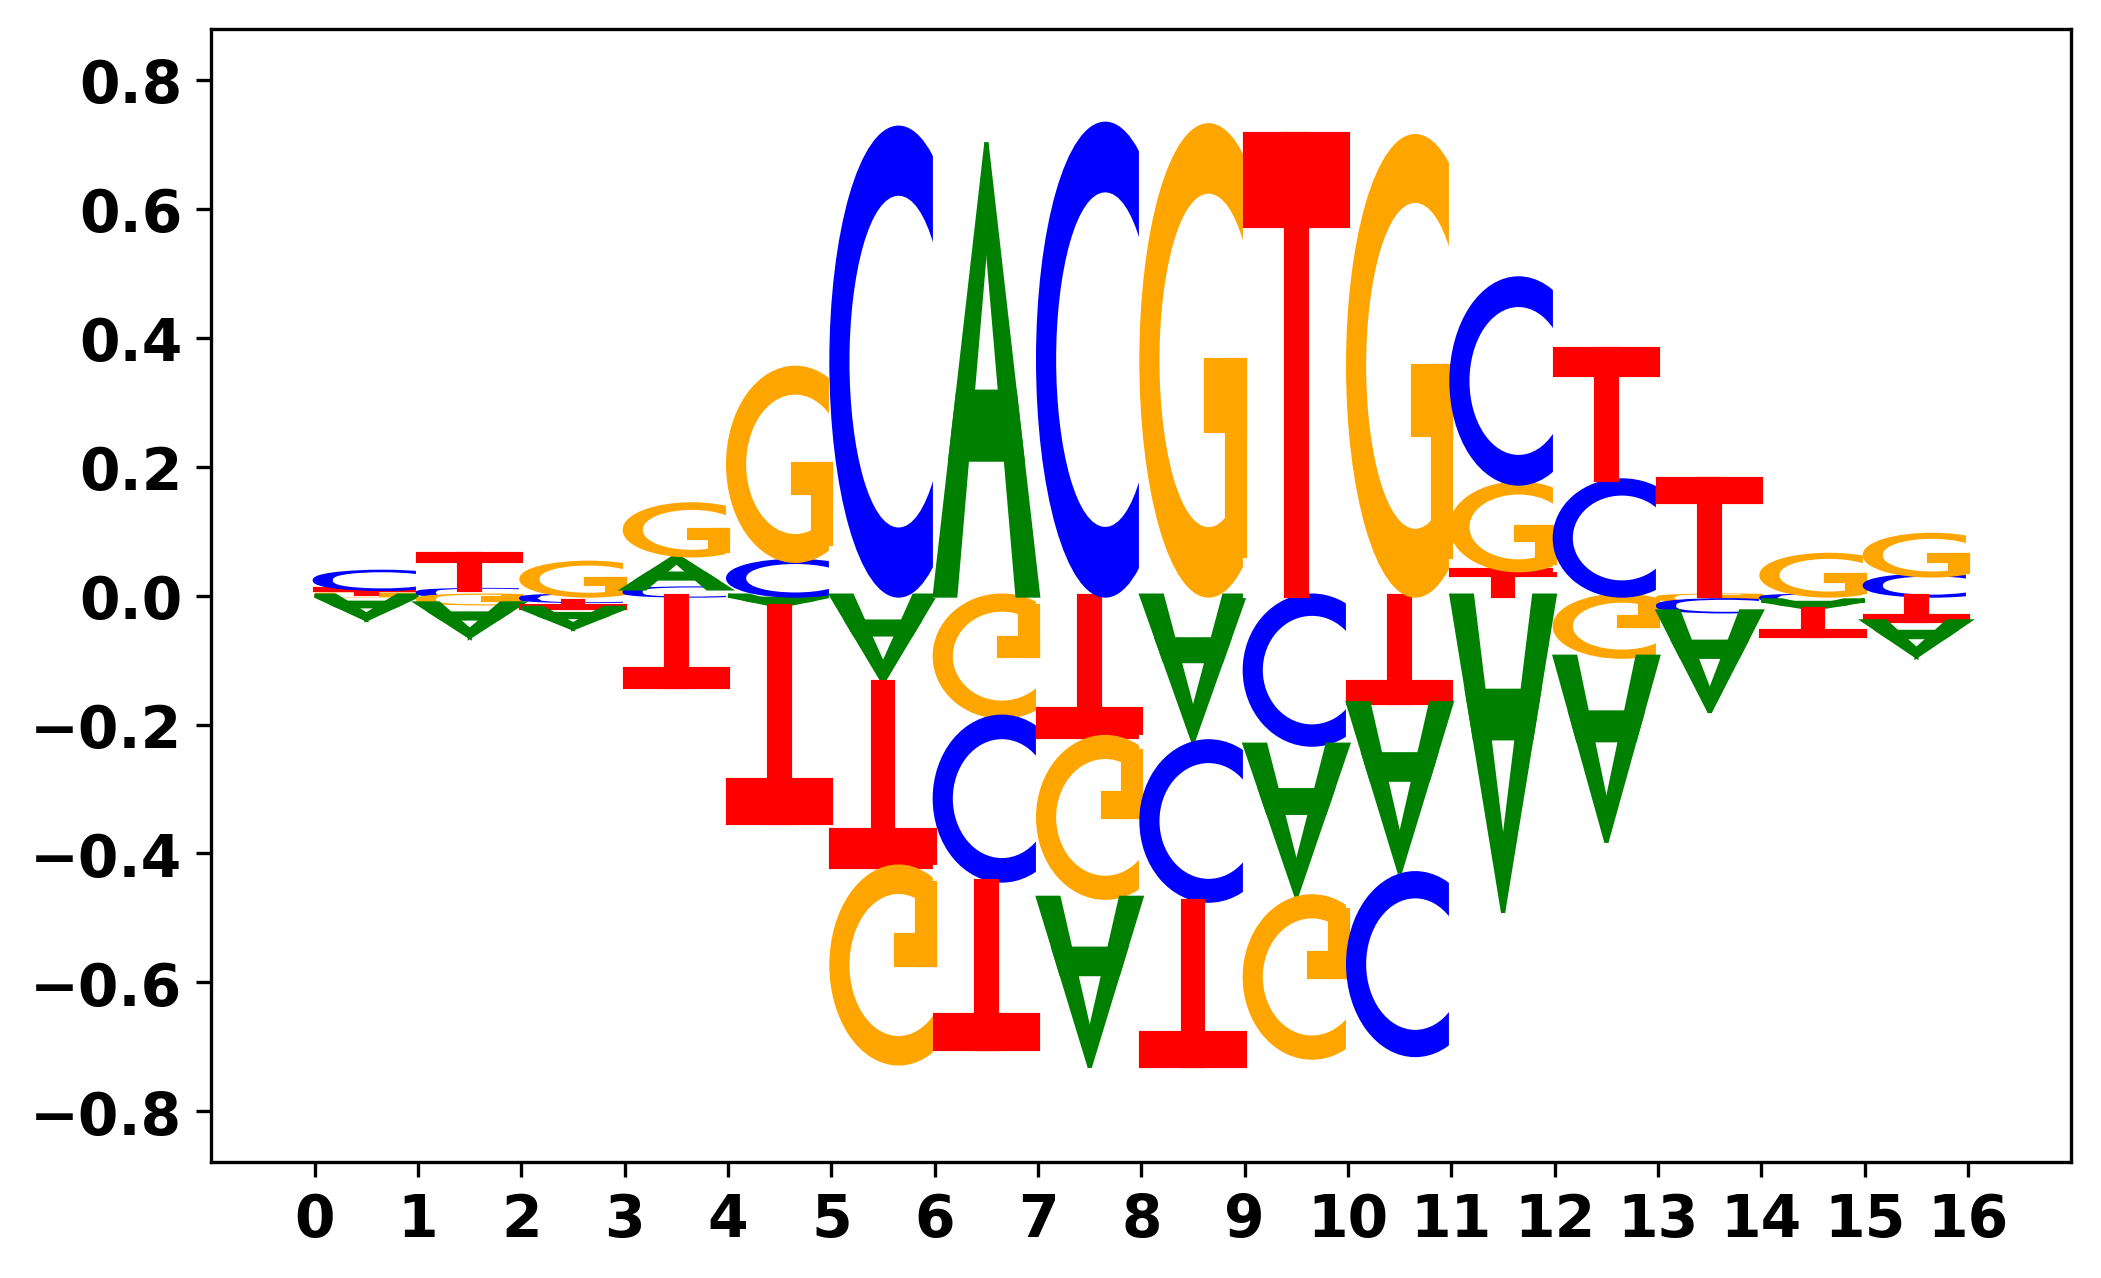

In [11]:
centered_matrix = np.array([i-np.mean(i) for i in distilled_matrix])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_matrix,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

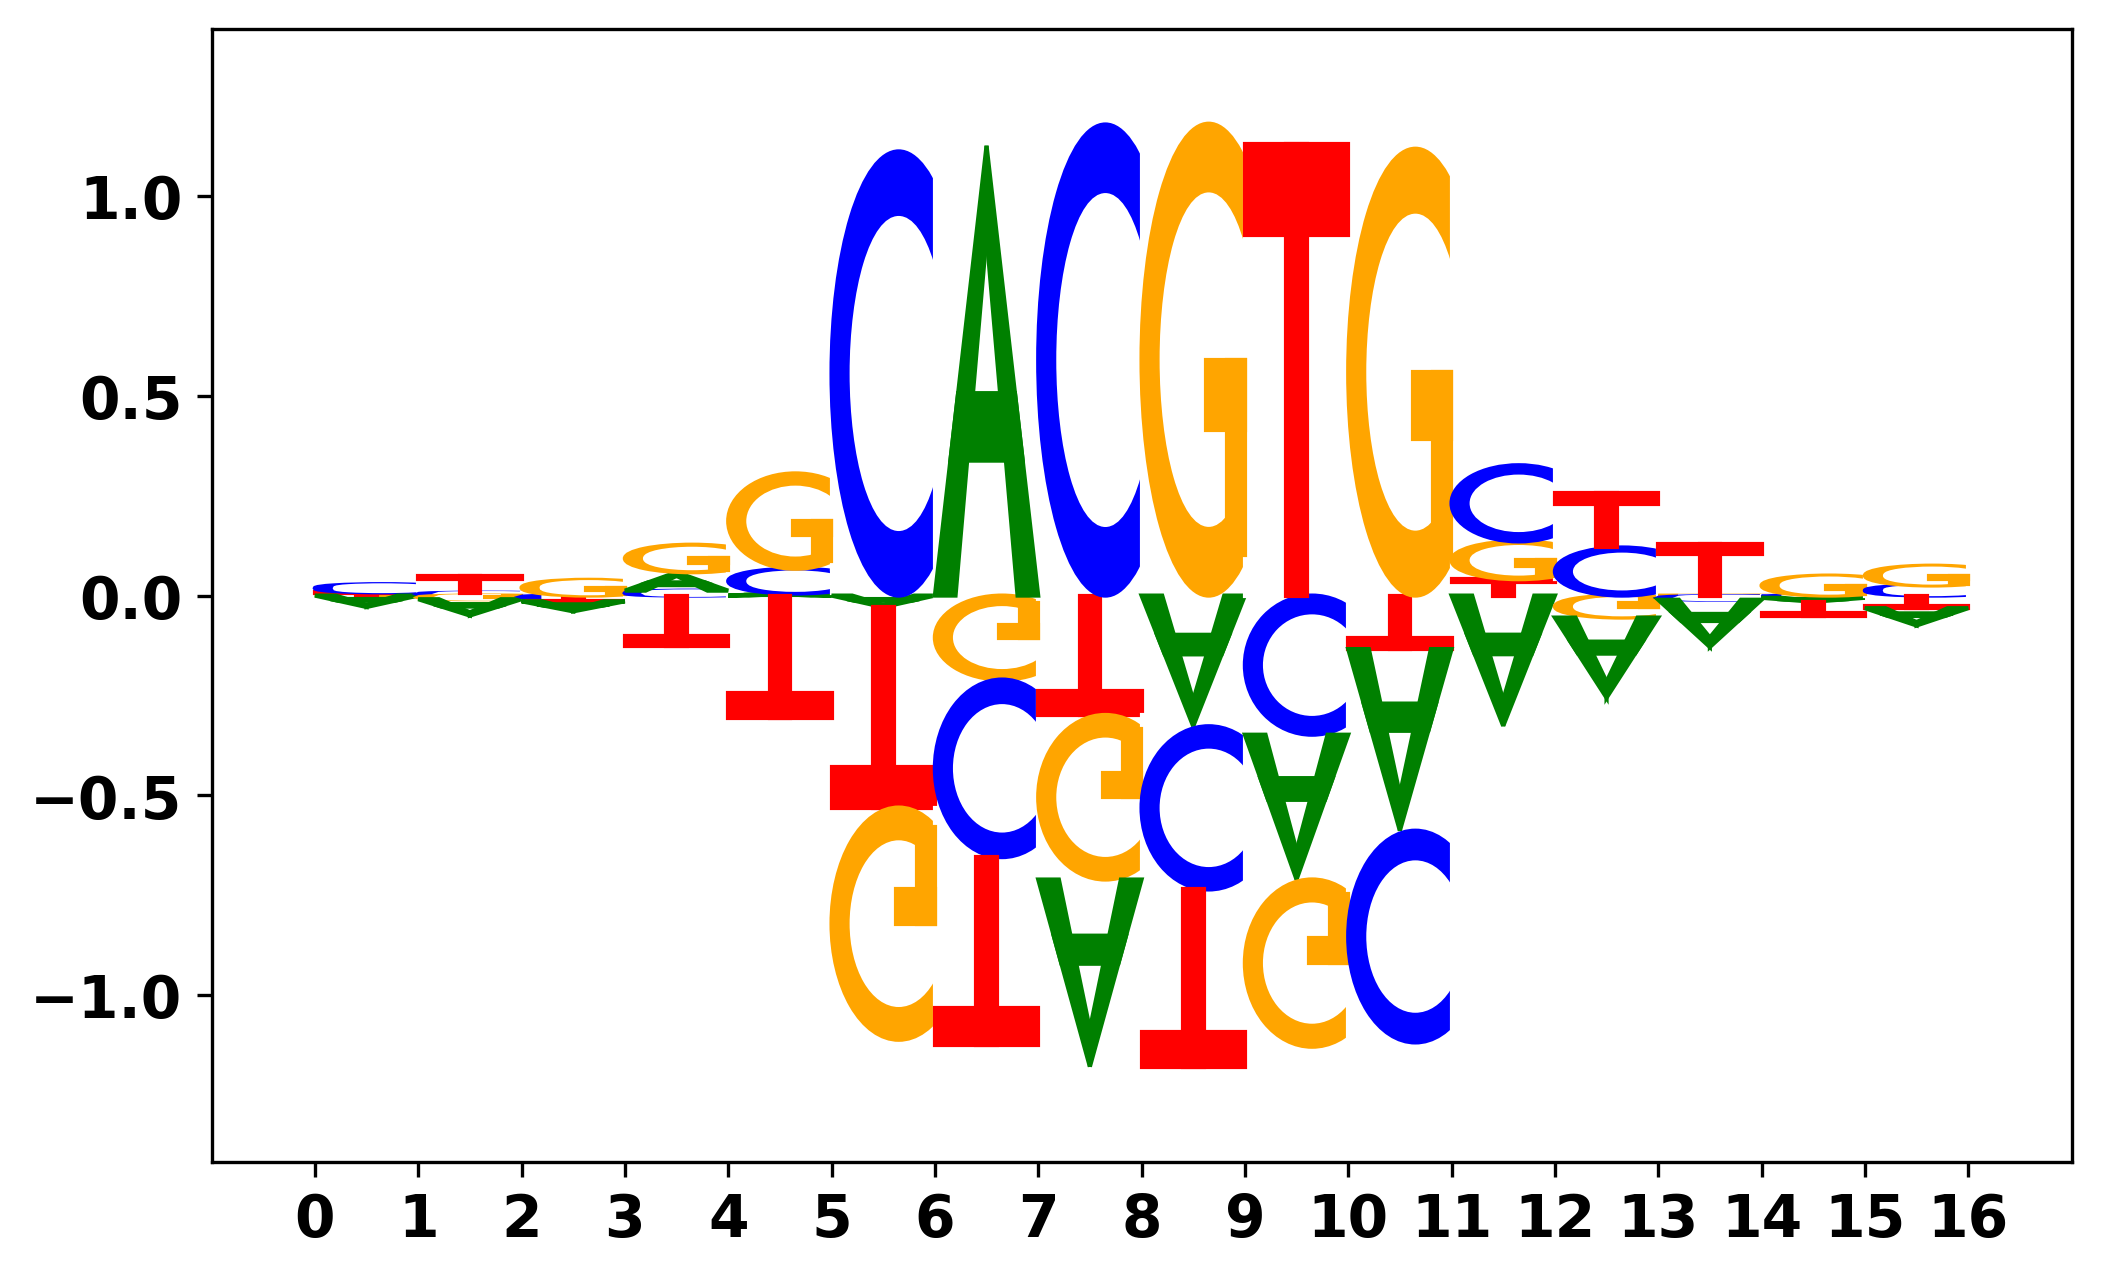

In [12]:
distilled_pwm = np.log((distilled_matrix/0.25)+1)
centered_distilled_pwm = np.array([i-np.mean(i) for i in distilled_pwm])
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8,5), dpi=300)
ax = fig.add_subplot(111)
viz_sequence.plot_weights_given_ax(ax, centered_distilled_pwm,
                                    height_padding_factor=0.2,
                                    length_padding=1.0,
                                    subticks_frequency=1.0,
                                    highlight={})

In [13]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("data/experimental/all_scaled_nn_preds.txt") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank,protein,_,_,_,ddG,_ = line.strip().split('\t')
        if protein == "Cbf1": flankToCbf1Ddg[flank] = float(ddG)
        else: flankToPho4Ddg[flank] = float(ddG)
        allFlanks.append(flank)
allFlanks = list(set(allFlanks))

In [14]:
def generate_matrix(seq):
    seq_matrix = np.zeros((4, len(seq)))
    for j in range(len(seq)):
        if seq[j] == 'A':
            seq_matrix[0,j] = 1
        elif seq[j] == 'C':
            seq_matrix[1,j] = 1
        elif seq[j] == 'G':
            seq_matrix[2,j] = 1
        elif seq[j] == 'T':
            seq_matrix[3,j] = 1
    return seq_matrix

def get_PWM_score(sequence, score_matrix):
    score = 0
    score_len = score_matrix.shape[0]
    for j in range(len(sequence) - score_len + 1):
        seq_matrix = generate_matrix(sequence[j:j+score_len])
        diagonal = np.diagonal(np.matmul(score_matrix, seq_matrix))
        score += np.prod(diagonal)
    return score

In [15]:
R=1.9872036e-3
T=295
flankToLogPSAM = {}
flankToDDGMatrix = {}
flankToDistilledMatrix = {}
flankToCenteredMatrix = {}
flankToDistilledPWM = {}
for flank in allFlanks:
    curr_seq = flank[:5]+"CACGTG"+flank[5:]
    flankToLogPSAM[flank] = R*T*np.log(get_PWM_score(curr_seq, PHO4_PSAM))
    flankToDDGMatrix[flank] = get_PWM_score(curr_seq, PHO4_ddG)
    flankToDistilledMatrix[flank] = get_PWM_score(curr_seq, distilled_matrix)
    flankToCenteredMatrix[flank] = get_PWM_score(curr_seq, centered_matrix)
    flankToDistilledPWM[flank] = get_PWM_score(curr_seq, distilled_pwm)

In [16]:
obj_text = codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToLogCountPreds = json.loads(obj_text)

In [17]:
flankToDeltaLogCount = {}
for flank in allFlanks:
    y_0 = np.array(flankToLogCountPreds[flank][0]).astype(float)
    y_1 = np.array(flankToLogCountPreds[flank][1]).astype(float)
    flankToDeltaLogCount[flank] = np.mean(y_1-y_0)

In [18]:
def fill_into_center(seq, insert):
    start = int((len(seq)/2.0)-(len(insert)/2.0))
    new_seq = seq[:start]+insert+seq[start+len(insert):]
    return new_seq

building_blocks = []
for idx in range(10):
    for cx in ['C', 'G', 'T']:
        new_seq = list(flank_consensus)
        new_seq[idx] = cx
        building_blocks.append("".join(new_seq))

buildingBlocksToDeltaLogCount = {}
for flank in building_blocks:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(peaks), num_samples, replace=False)
    for idx in indices:
        base_seq = dinuc_shuffle(peaks[idx])
        pre_seq = fill_into_center(base_seq, consensus)
        curr_seq = flank[:5]+"CACGTG"+flank[5:]
        post_seq = fill_into_center(base_seq, curr_seq)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    buildingBlocksToDeltaLogCount[flank] = np.mean(post[0]-pre[0])

In [19]:
flankToAdditiveDLC = {}
for flank in allFlanks:
    score = flankToDeltaLogCount[flank_consensus]
    for idx in range(len(flank_consensus)):
        if flank_consensus[idx] != flank[idx]:
            new_seq = list(flank_consensus)
            new_seq[idx] = flank[idx]
            to_score = "".join(new_seq)
            score += buildingBlocksToDeltaLogCount[to_score]
    flankToAdditiveDLC[flank] = score

In [20]:
xvals_pho4 = []
xvals_cbf1 = []
for flank in allFlanks:
    xvals_pho4.append(flankToPho4Ddg[flank])
    xvals_cbf1.append(flankToCbf1Ddg[flank])

spearman:  -0.9612980668619657
pearson:  -0.9597240518608552
residuals:  15114.670753334982
oom:  1.0


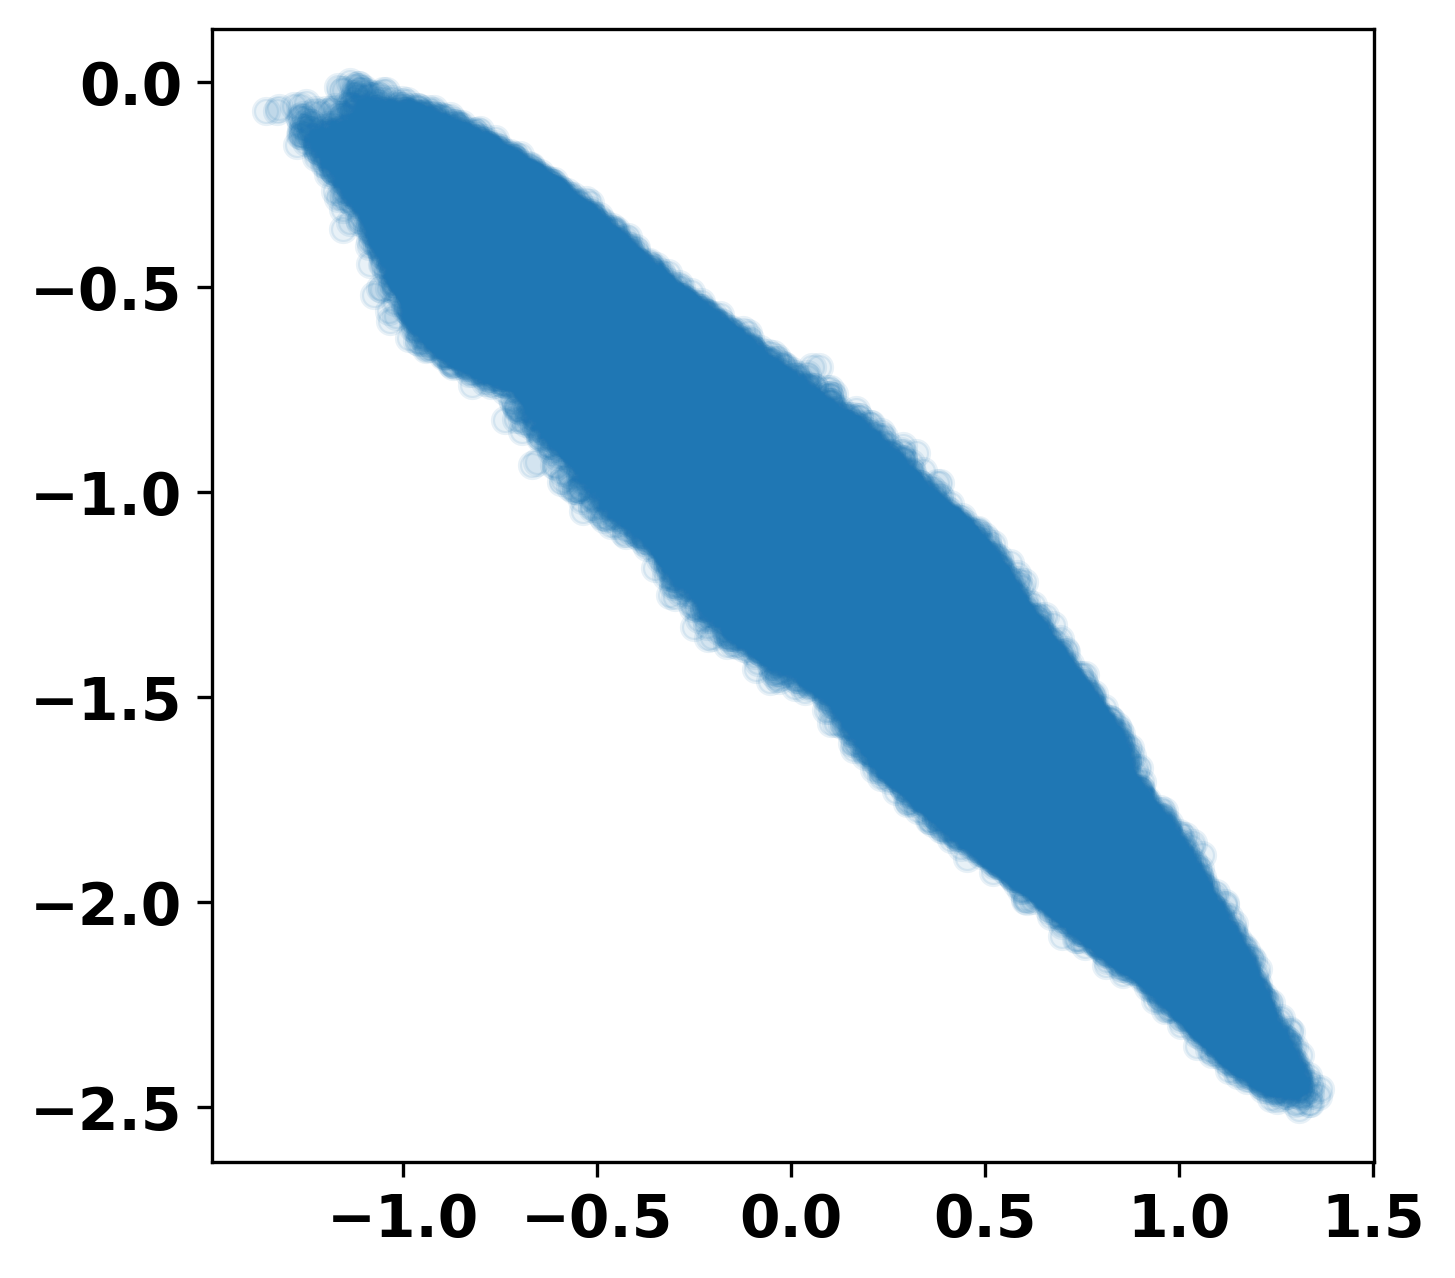

spearman:  -6.560216027972019e-05
pearson:  -3.0486218127628525e-06
residuals:  4626.125861445243
oom:  1e-09


<Figure size 432x288 with 0 Axes>

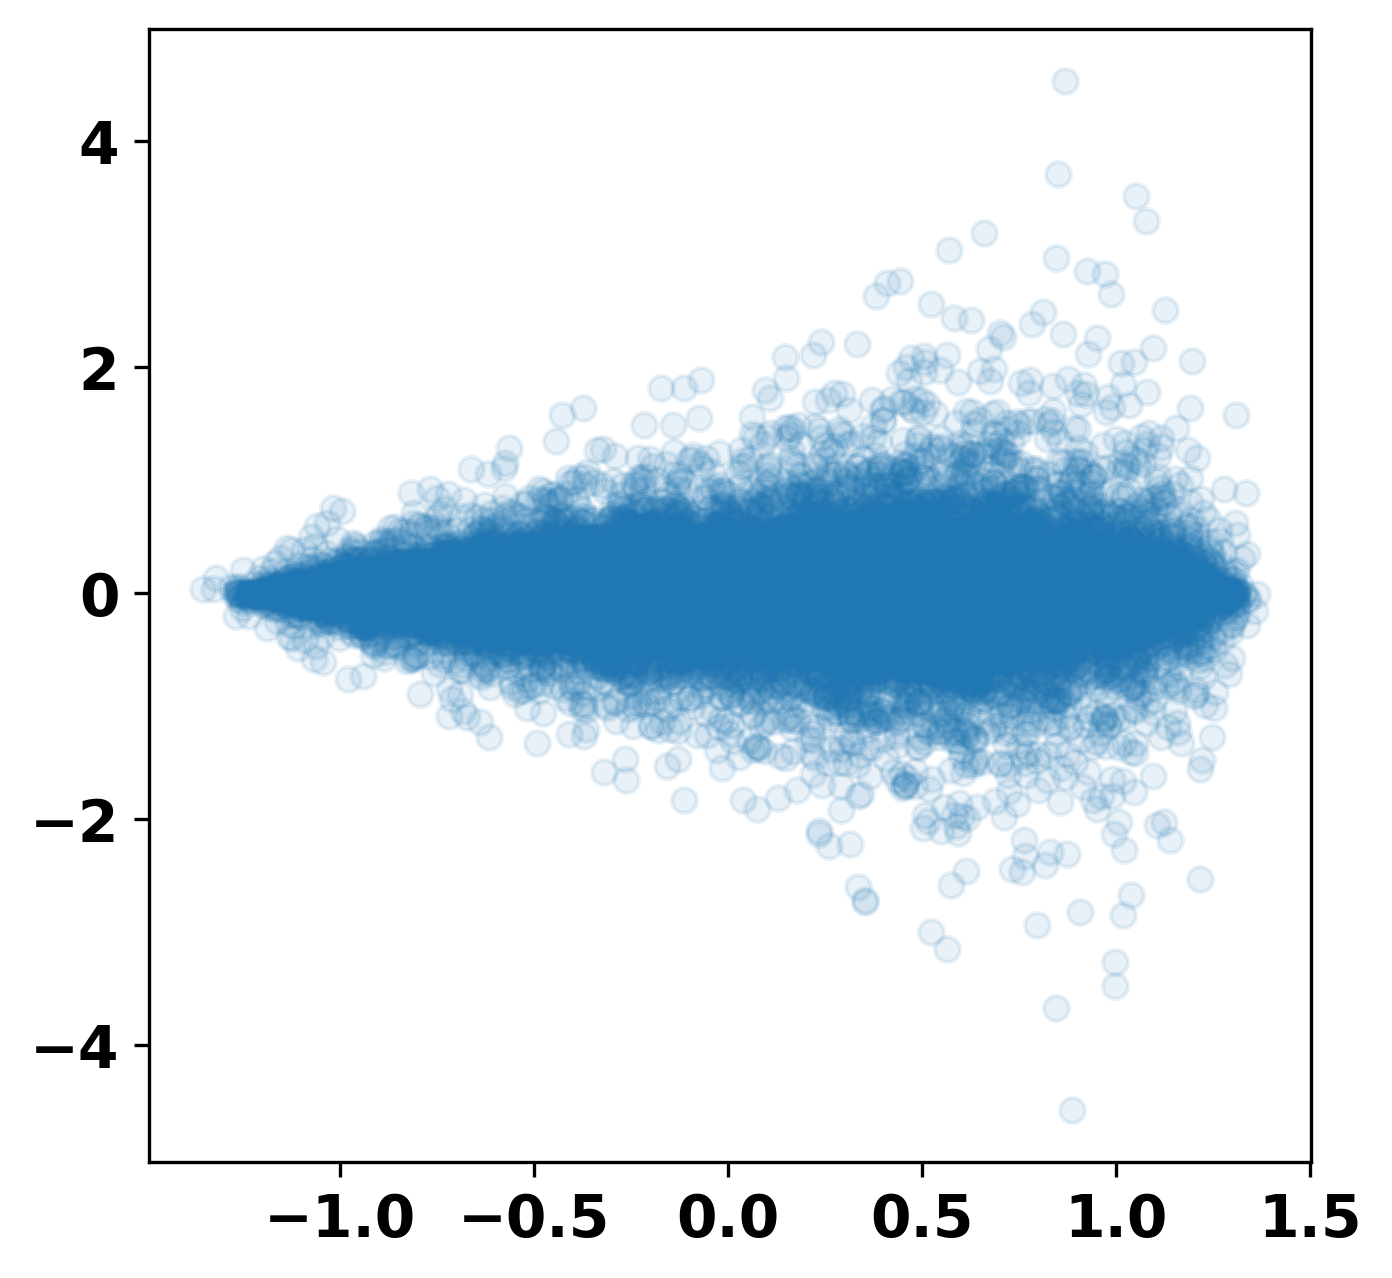

spearman:  -0.8607916119300852
pearson:  -0.8230242274228904
residuals:  173407.21845904758
oom:  1.0


<Figure size 432x288 with 0 Axes>

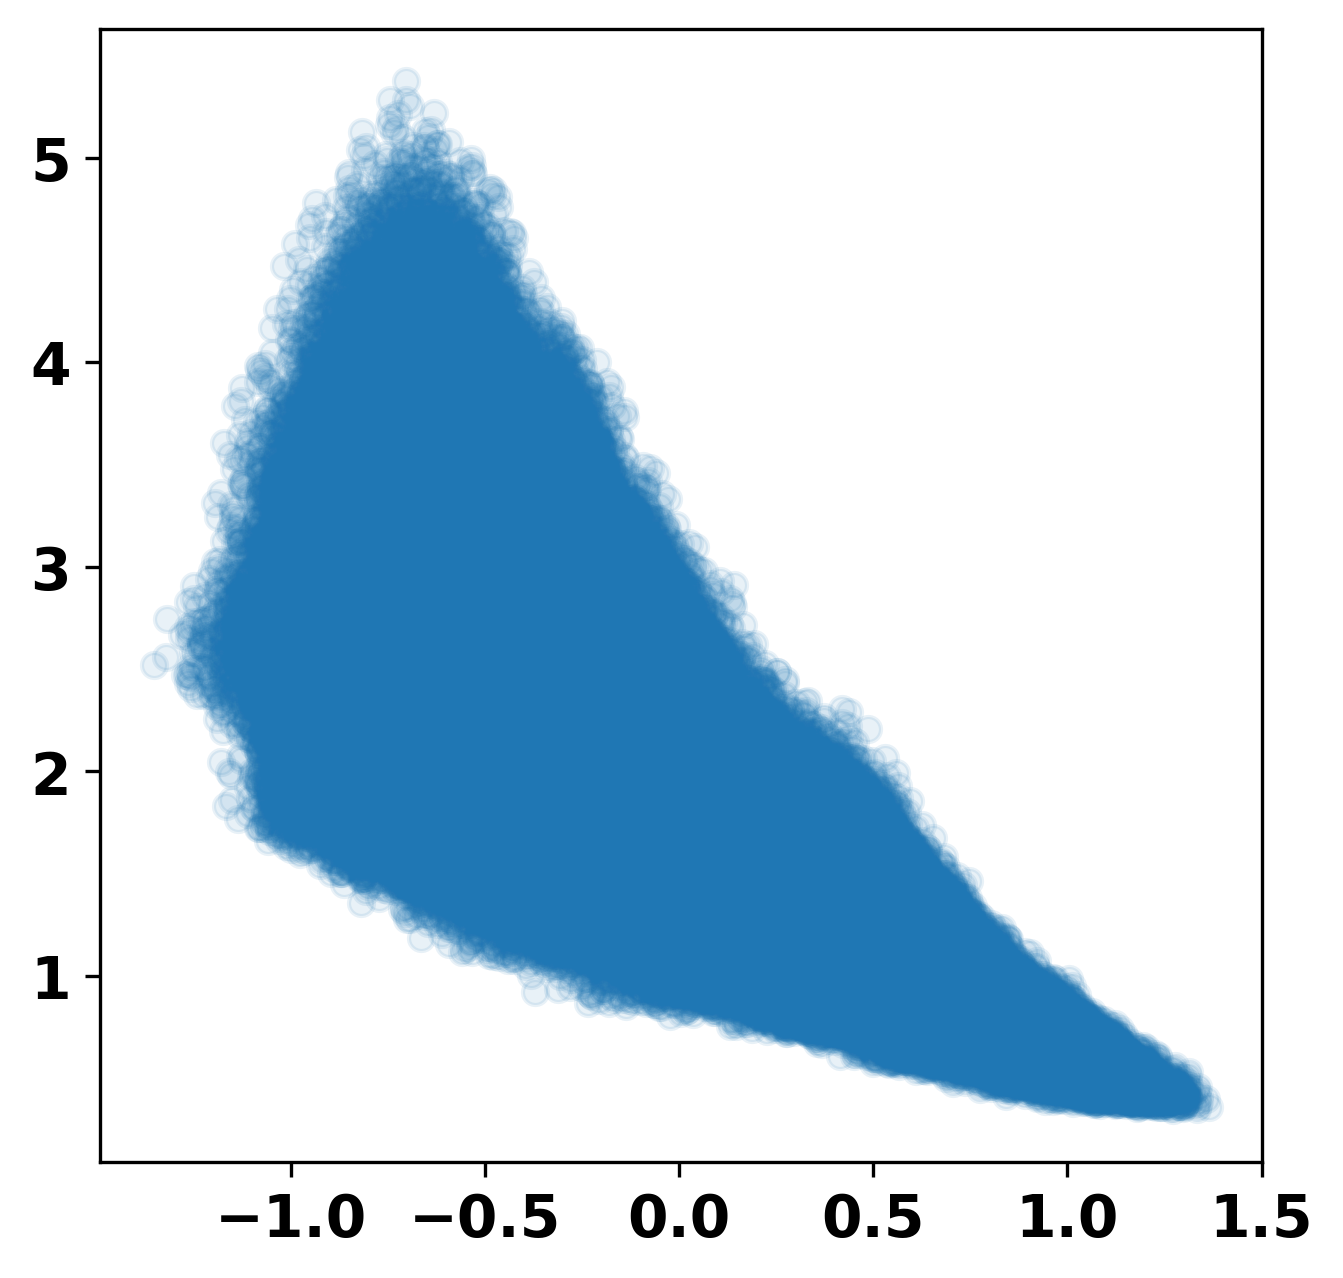

spearman:  -1.0542742206560043e-05
pearson:  1.6510615443073016e-05
residuals:  11317.838788608384
oom:  1e-11


<Figure size 432x288 with 0 Axes>

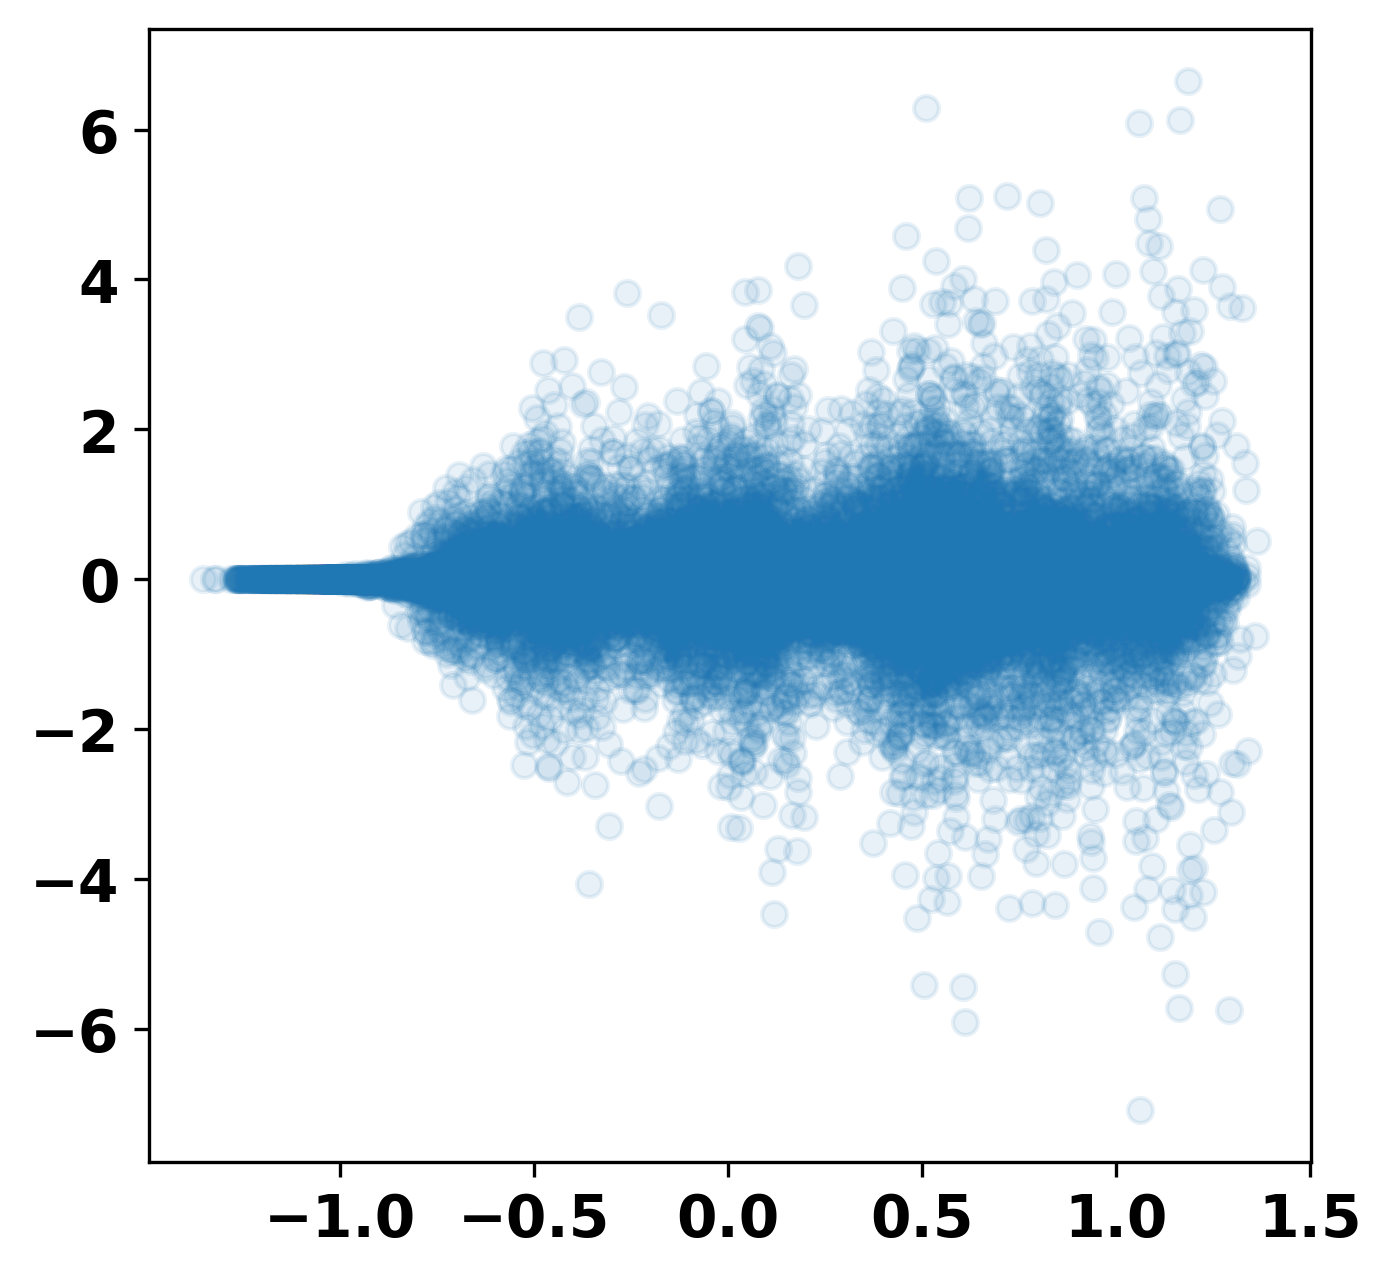

spearman:  -0.8627589353093897
pearson:  -0.8533050601410365
residuals:  75262.01178679359
oom:  1000.0


<Figure size 432x288 with 0 Axes>

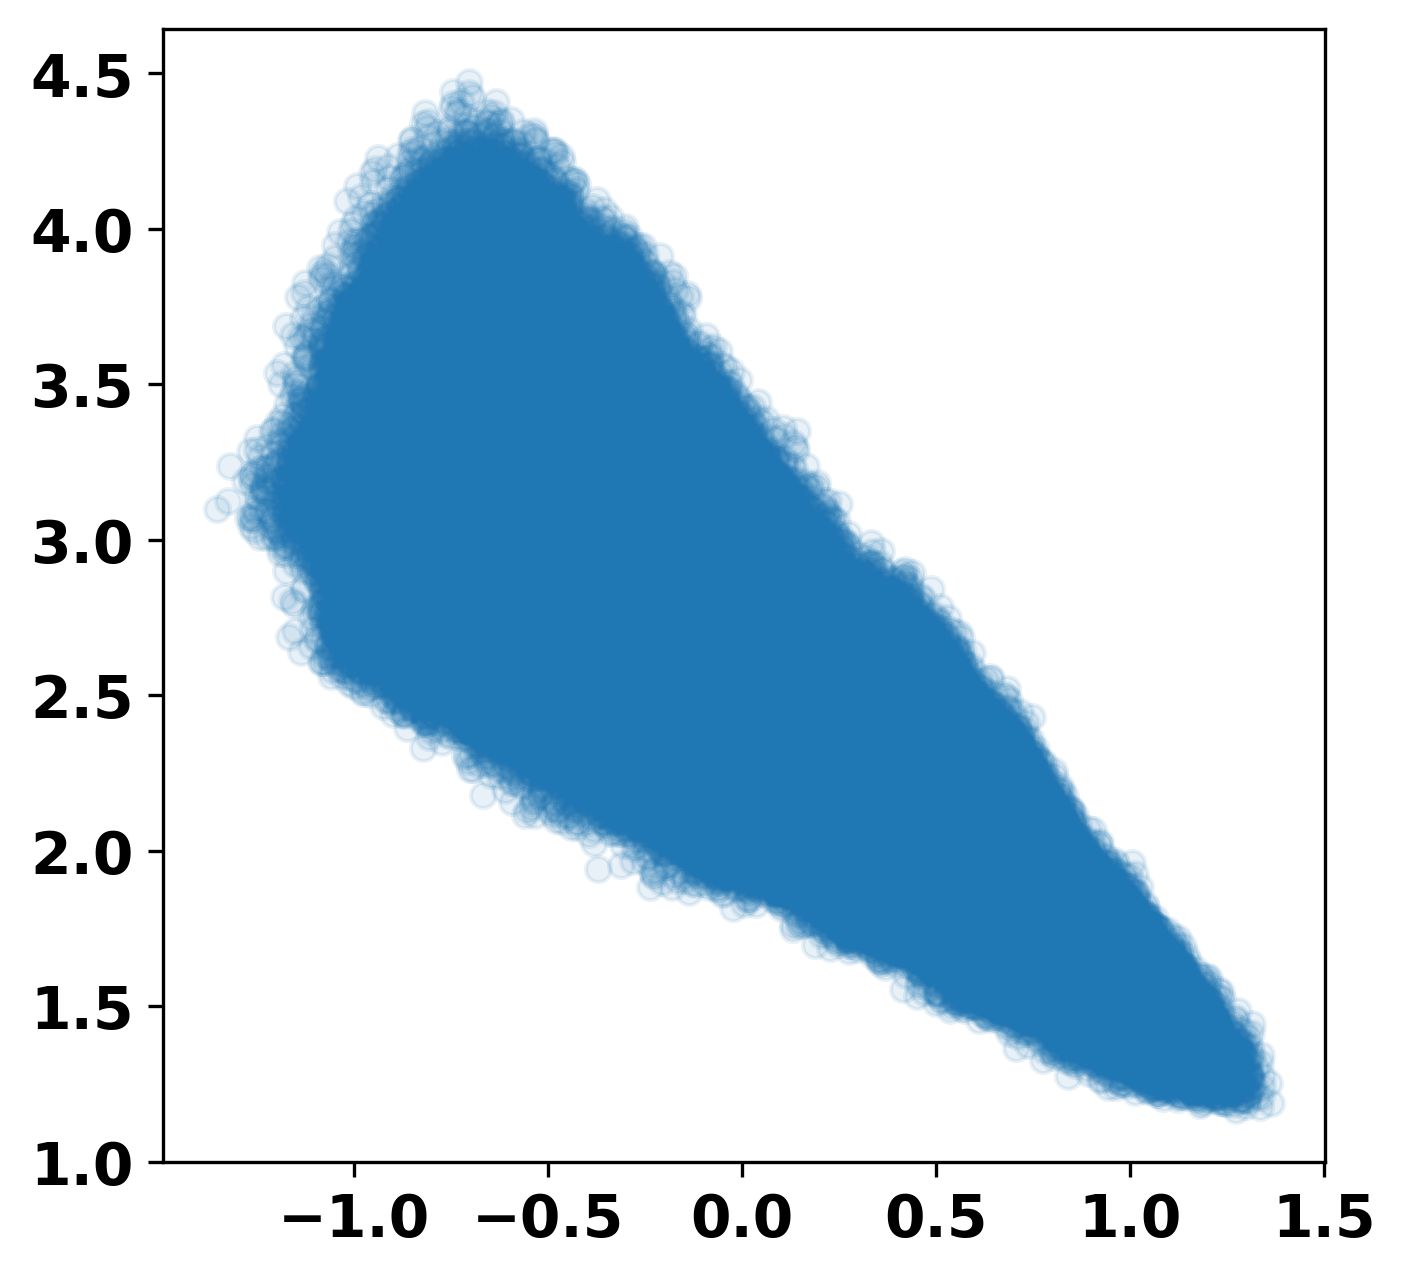

spearman:  -0.8530909827447425
pearson:  -0.8592490373800828
residuals:  57734.81891757192
oom:  1.0


<Figure size 432x288 with 0 Axes>

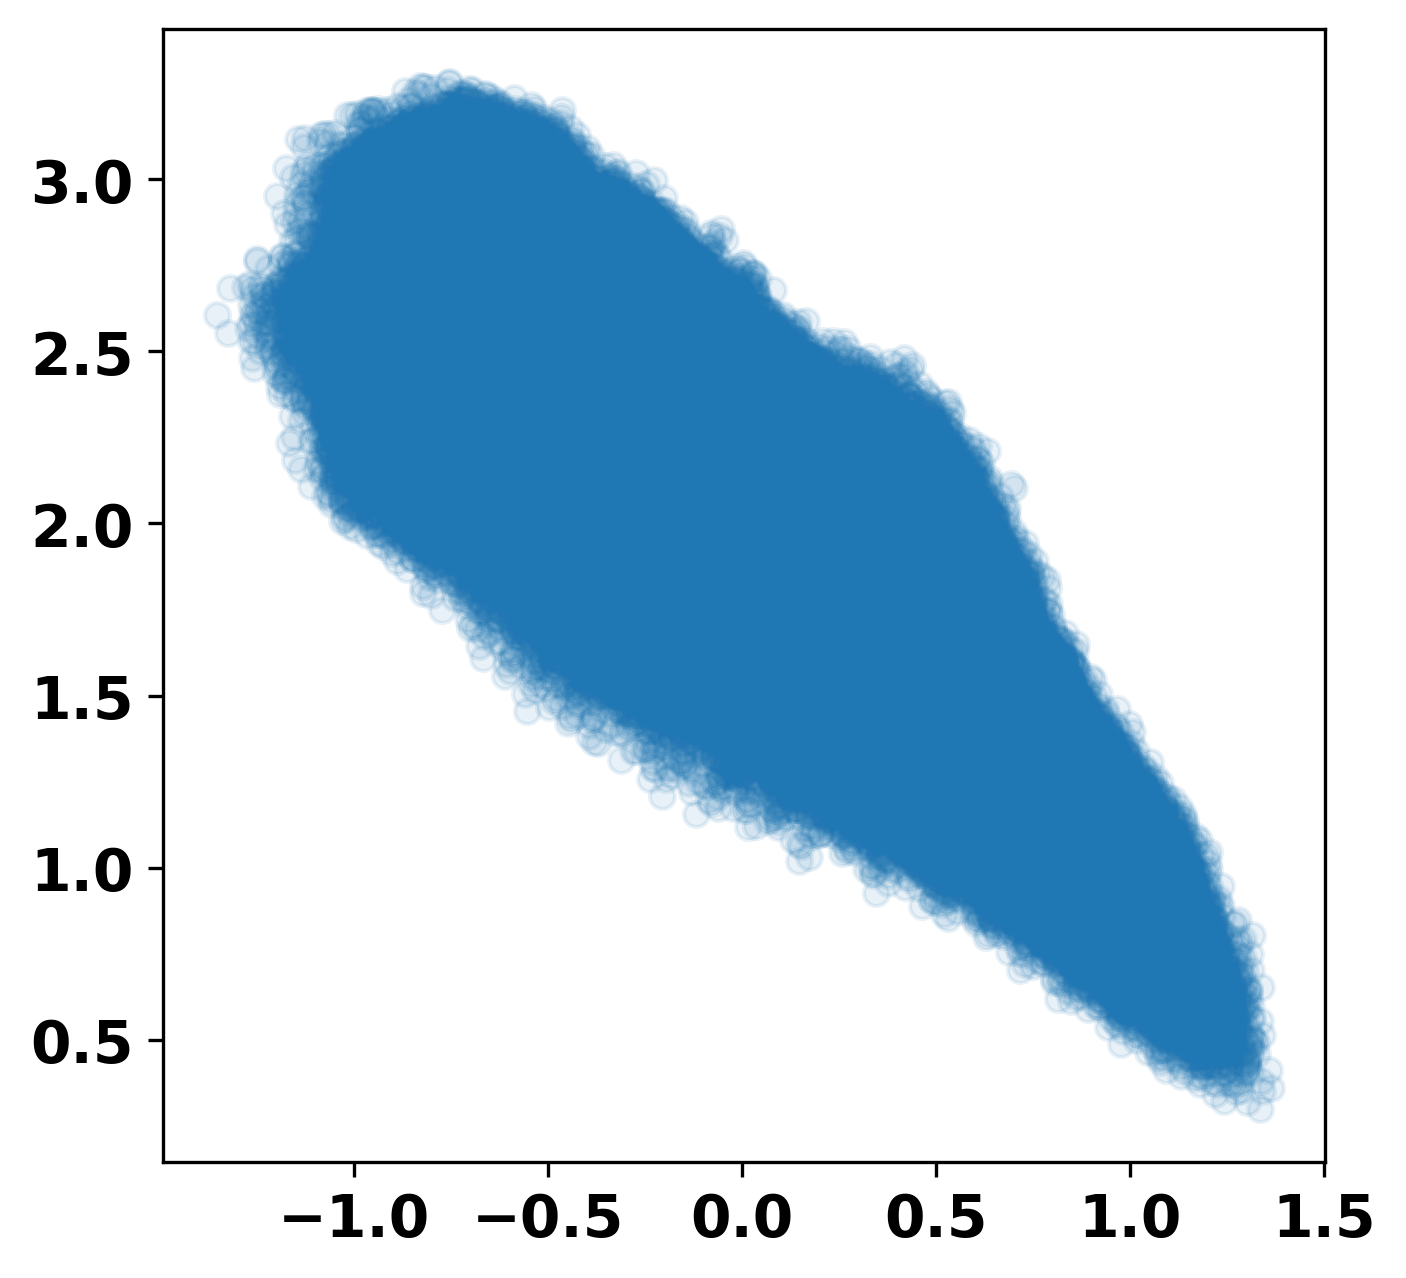

spearman:  -0.9021943497245583
pearson:  -0.9002647092956957
residuals:  27652.587751089868
oom:  1.0


<Figure size 432x288 with 0 Axes>

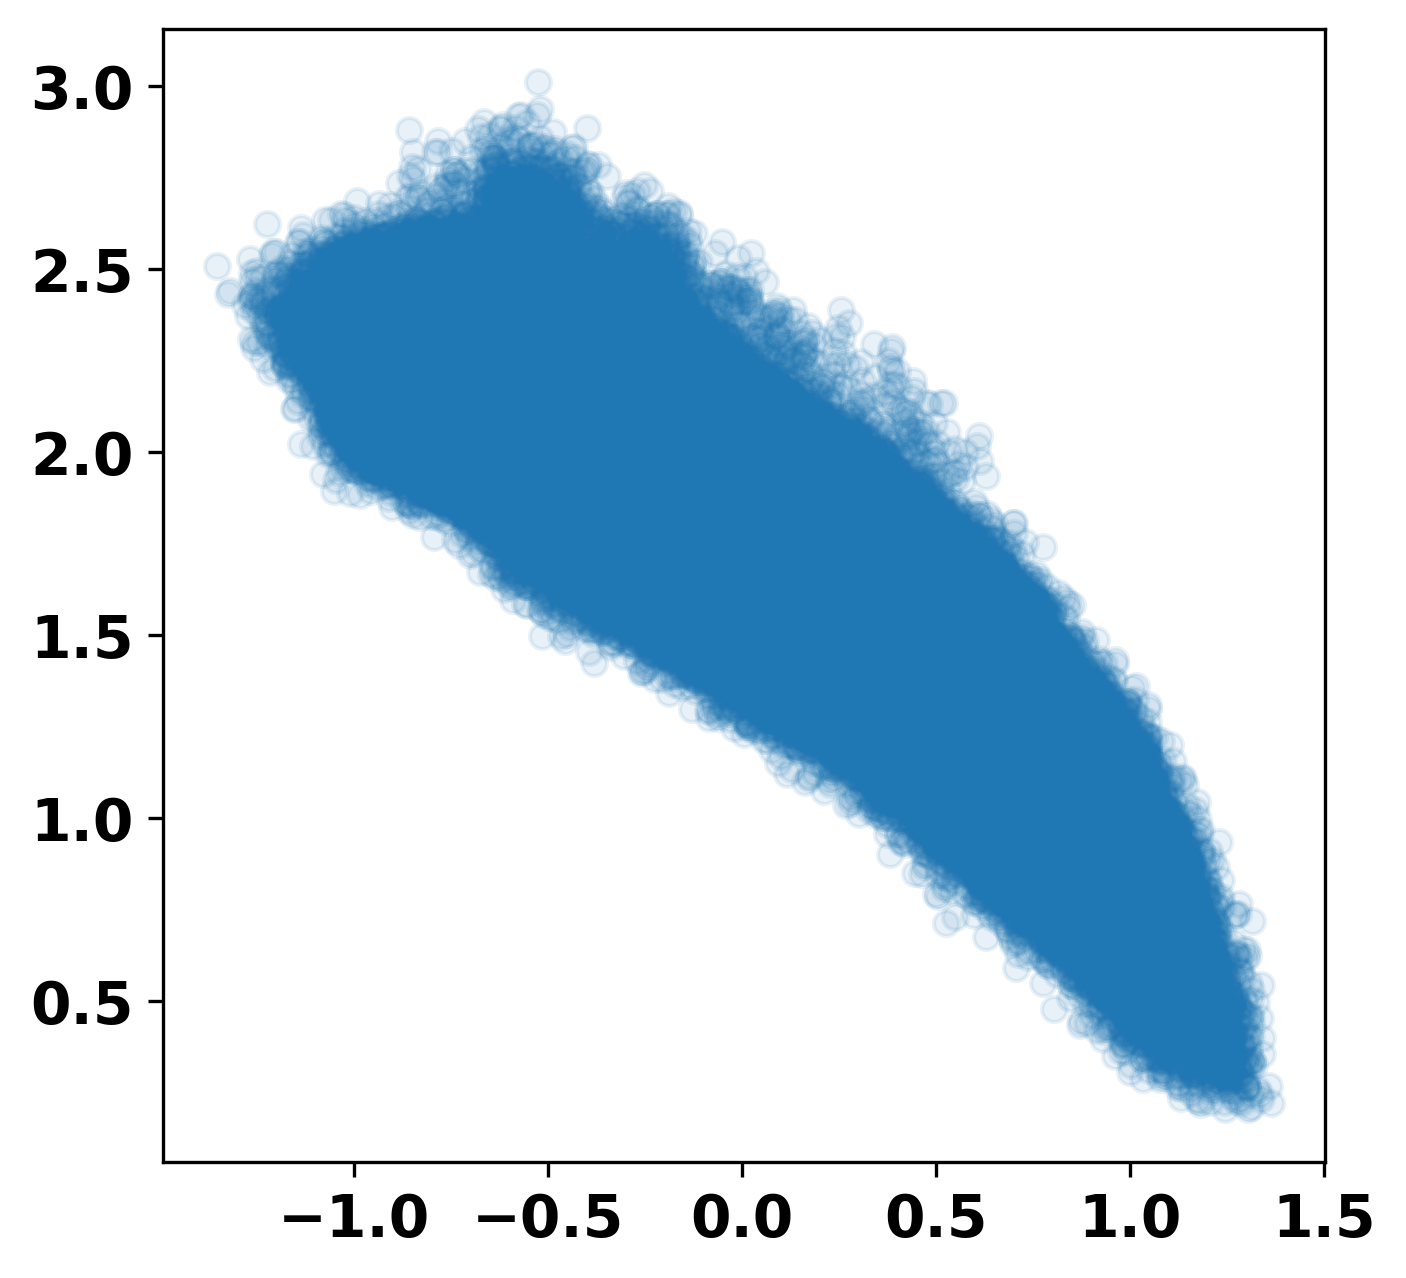

<Figure size 432x288 with 0 Axes>

In [21]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

for preds in [flankToLogPSAM,
              flankToDDGMatrix,
              flankToDistilledMatrix,
              flankToCenteredMatrix,
              flankToDistilledPWM,
              flankToAdditiveDLC,
              flankToDeltaLogCount]:
    yvals = []
    for flank in allFlanks: yvals.append(preds[flank])
    yvals = np.array(yvals)
    oom = orderOfMagnitude(np.max(np.abs(yvals)))
    yvals = yvals/(10.0**oom)
    xvals = xvals_pho4
#     if "pho4" in key: xvals = xvals_pho4
#     else: xvals = xvals_cbf1
    print("spearman: ", spearmanr(xvals, yvals)[0])
    print("pearson: ", pearsonr(xvals, yvals)[0])
    print("residuals: ", np.polyfit(xvals, yvals, 1, full=True)[1][0])
    print("oom: ", 10.0**oom)
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(111)
    plt.scatter(xvals, yvals, alpha=0.1)
    plt.show()
    plt.clf()
    
#     meta = {}
#     meta["key"] = key
#     meta["x-axis"] = "ddG"
#     meta["y-axis"] = "MEME based PWM scores -- scale = "+str(10.0**oom)
#     meta["Number of points"] = len(xvals)
#     meta["spearman"] = spearmanr(xvals, yvals)[0]
#     meta["pearson"] = pearsonr(xvals, yvals)[0]
#     # Residuals is sum of squared residuals of the least-squares fit
#     meta["residuals"] = np.polyfit(xvals, yvals, 1, full=True)[1][0]
#     # ax.set_xlim((1,5.75))
#     # ax.set_ylim((1,5.75))
#     # ax.set_aspect('equal')
#     fig.savefig(key+'_MEME_baseline.png', dpi=300)
#     plt.clf()
#     with open(key+'_MEME_metadata.json', 'w') as fp: json.dump(meta, fp)